# 🧪 Final Prototype – Multi-Modal GAN Image Colourisation (Prototype 3)

Welcome to the final stage of my GAN-based image colourisation project.

In this notebook, I implement **Prototype 3**, which introduces **multi-modal capabilities** to my GAN architecture. This allows the system to generate **multiple plausible colour outputs** for a single greyscale input, handling ambiguous scenarios (e.g., skies, fabrics, lighting) more intelligently.

This prototype builds on my earlier work, using a **CBAM-enhanced U-Net generator**, and extends it with **latent noise injection** for diversity. The goal is to move toward real-time, user-interactive image colourisation with control over style and variability.


## 📦 Importing Libraries

Here I import all necessary Python libraries for loading data, defining the GAN architecture, and performing inference with visualisation.


In [ ]:
# Standard ML and image processing tools
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# For working with image arrays
from PIL import Image


## 🧠 Define Generator with Hierarchical Attention and Latent Noise Input

In this section, I define the full generator architecture, based on a U-Net with **CBAM attention** and support for latent vector injection.

The model accepts a **greyscale image + noise map**, which are concatenated to form the 2-channel input. This allows the generator to create **different results per input**, depending on the random noise.


In [ ]:
# CBAM modules for hierarchical attention
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_mlp(self.avg_pool(x))
        max = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg + max)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max, _ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(self.conv(torch.cat([avg, max], dim=1)))

class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        return x * self.spatial_attention(x)


In [ ]:
# Generator that takes (greyscale + noise) input
class UNetGeneratorCBAM_Multimodal(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = self.block(2, 64, batch_norm=False)  # 👈 2-channel input
        self.cbam1 = CBAM(64)

        self.down2 = self.block(64, 128)
        self.cbam2 = CBAM(128)

        self.down3 = self.block(128, 256)
        self.cbam3 = CBAM(256)

        self.down4 = self.block(256, 512)
        self.cbam4 = CBAM(512)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.ReLU()
        )

        self.up1 = self.up_block(1024, 512)
        self.up2 = self.up_block(1024, 256)
        self.up3 = self.up_block(512, 128)
        self.up4 = self.up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def block(self, in_c, out_c, batch_norm=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1), nn.LeakyReLU(0.2)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_c))
        return nn.Sequential(*layers)

    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_c)
        )

    def forward(self, x, z):
        x = torch.cat([x, z], dim=1)  # Concatenate greyscale + noise
        d1 = self.cbam1(self.down1(x))
        d2 = self.cbam2(self.down2(d1))
        d3 = self.cbam3(self.down3(d2))
        d4 = self.cbam4(self.down4(d3))

        bn = self.bottleneck(d4)

        u1 = self.up1(bn)
        u1 = torch.cat([u1, d4], dim=1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d3], dim=1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d2], dim=1)

        u4 = self.up4(u3)
        u4 = torch.cat([u4, d1], dim=1)

        return self.final(u4)


## 💾 Load Pretrained Weights (with Compatibility Fix)

My current generator architecture uses a 2-channel input (greyscale + latent noise), but my saved weights from Prototype 2 were trained on a 1-channel greyscale input.

To work around this, I manually remove the incompatible weights from the saved checkpoint (`down1.0.weight`, etc.) and load the rest. This lets me retain the valuable pretrained layers (CBAM blocks, decoder, etc.) while retraining only the first convolutional layer.



In [5]:
# ✅ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔧 Instantiate the Prototype 3 generator with 2-channel input
generator = UNetGeneratorCBAM_Multimodal().to(device)

# 🔁 Load pretrained weights, skipping first conv layer (1→2 channel mismatch)
try:
    state_dict = torch.load("model.pth", map_location=device)

    # Drop incompatible keys
    removed_keys = [k for k in state_dict if "down1.0" in k]
    for k in removed_keys:
        print(f"⚠️ Skipping incompatible weight: {k}")
        del state_dict[k]

    generator.load_state_dict(state_dict, strict=False)
    print("✅ Loaded pretrained weights (excluding down1).")

except Exception as e:
    print("❌ Could not load weights:", e)

generator.eval()


⚠️ Skipping incompatible weight: down1.0.weight
⚠️ Skipping incompatible weight: down1.0.bias
✅ Loaded pretrained weights (excluding down1).


UNetGeneratorCBAM_Multimodal(
  (down1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (cbam1): CBAM(
    (channel_attention): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (shared_mlp): Sequential(
        (0): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (sigmoid): Sigmoid()
    )
    (spatial_attention): SpatialAttention(
      (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (sigmoid): Sigmoid()
    )
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cbam2): CBAM(
    (channel_attention): ChannelAttention(
 

## 🧪 Load Real Test Inputs from CIFAR-10

Here I load a batch of real colour images from the CIFAR-10 test set and convert them to greyscale. This lets me evaluate how well my generator performs on **structured, realistic input** data.

CIFAR-10 is a 10-class dataset of 32×32 colour images, used in Prototypes 1 and 2.


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Convert to greyscale and then to tensor
greyscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Also load the original colour version (for reference)
colour_transform = transforms.ToTensor()

# Load CIFAR-10 test set (download once)
cifar10_grey = datasets.CIFAR10(root="./data", train=False, download=True, transform=greyscale_transform)
cifar10_colour = datasets.CIFAR10(root="./data", train=False, download=True, transform=colour_transform)

# Batch loader
batch_size = 4
grey_loader = DataLoader(cifar10_grey, batch_size=batch_size, shuffle=True)
colour_loader = DataLoader(cifar10_colour, batch_size=batch_size, shuffle=True)

# Grab one batch
greyscale_batch, _ = next(iter(grey_loader))
original_colour_batch, _ = next(iter(colour_loader))

# Move to device
greyscale_batch = greyscale_batch.to(device)

print("✅ CIFAR-10 batch loaded. Shape:", greyscale_batch.shape)


✅ CIFAR-10 batch loaded. Shape: torch.Size([4, 1, 32, 32])


## 🔁 Define CIFAR-10 Colourisation Dataset

Here I define a custom PyTorch dataset that returns paired `(greyscale, colour)` images from the CIFAR-10 training set. These are used to train the generator to learn mappings from structure to realistic colour.


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

# Transform: full-colour and greyscale version
to_tensor = transforms.ToTensor()
to_grey = transforms.Grayscale(num_output_channels=1)

class ColourisationDataset(Dataset):
    def __init__(self, root="./data"):
        self.data = datasets.CIFAR10(root=root, train=True, download=True, transform=to_tensor)
        self.to_grey = to_grey

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        colour_img, _ = self.data[idx]
        grey_img = self.to_grey(transforms.ToPILImage()(colour_img))
        grey_tensor = transforms.ToTensor()(grey_img)
        return grey_tensor, colour_img

# Load dataset
train_dataset = ColourisationDataset()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


## 🎯 Discriminator & Training Setup

To fine-tune the generator, I introduce a simple discriminator that learns to distinguish real colour images from generated ones.

This GAN setup uses:
- L1 Loss: pixel-wise reconstruction
- BCE Loss: adversarial realism
- Adam optimisers for both models


In [13]:
# Simple discriminator (CNN)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
discriminator = Discriminator().to(device)

# Losses
criterion_L1 = nn.L1Loss()
criterion_adv = nn.BCELoss()

# Optimisers
lr = 2e-4
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


## 🔁 Fine-Tuning Generator on CIFAR-10

Now I train the generator using the full CIFAR-10 training set. The generator receives `(greyscale + noise)` as input and tries to match the real colour target.

The discriminator guides the realism, while L1 loss ensures structural fidelity.


In [33]:
from tqdm import tqdm

epochs = 50

for epoch in range(epochs):
    g_loss_total, d_loss_total = 0, 0

    for grey, colour in tqdm(train_loader):
        grey, colour = grey.to(device), colour.to(device)

        # === Train Discriminator ===

        # 1. Real pass
        real_out = discriminator(colour)
        real_labels = torch.ones_like(real_out).to(device)
        d_loss_real = criterion_adv(real_out, real_labels)

        # 2. Fake pass
        z = torch.randn_like(grey)
        fake_imgs = generator(grey, z)
        fake_out = discriminator(fake_imgs.detach())
        fake_labels = torch.zeros_like(fake_out).to(device)
        d_loss_fake = criterion_adv(fake_out, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # === Train Generator ===
        fake_out = discriminator(fake_imgs)  # re-evaluate
        real_labels = torch.ones_like(fake_out).to(device)
        g_adv_loss = criterion_adv(fake_out, real_labels)
        g_recon_loss = criterion_L1(fake_imgs, colour)
        g_loss = g_adv_loss + 100 * g_recon_loss

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()

    print(f"Epoch {epoch+1}/{epochs} | G Loss: {g_loss_total:.4f} | D Loss: {d_loss_total:.4f}")

    # Save model every few epochs
    if (epoch + 1) % 5 == 0:
        torch.save(generator.state_dict(), f"generator_epoch{epoch+1}.pth")



100%|██████████| 782/782 [02:00<00:00,  6.51it/s]


Epoch 1/50 | G Loss: 4232.0895 | D Loss: 654.4197


100%|██████████| 782/782 [01:53<00:00,  6.90it/s]


Epoch 2/50 | G Loss: 4966.9498 | D Loss: 327.2879


100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


Epoch 3/50 | G Loss: 5565.4104 | D Loss: 191.1589


100%|██████████| 782/782 [01:47<00:00,  7.28it/s]


Epoch 4/50 | G Loss: 6081.7202 | D Loss: 122.6546


100%|██████████| 782/782 [01:42<00:00,  7.60it/s]


Epoch 5/50 | G Loss: 6531.8027 | D Loss: 86.8613


100%|██████████| 782/782 [01:48<00:00,  7.22it/s]


Epoch 6/50 | G Loss: 6929.3616 | D Loss: 61.0287


100%|██████████| 782/782 [01:42<00:00,  7.65it/s]


Epoch 7/50 | G Loss: 7317.9924 | D Loss: 41.3485


100%|██████████| 782/782 [01:38<00:00,  7.97it/s]


Epoch 8/50 | G Loss: 7552.8482 | D Loss: 44.0593


100%|██████████| 782/782 [01:47<00:00,  7.31it/s]


Epoch 9/50 | G Loss: 7820.4458 | D Loss: 43.9805


100%|██████████| 782/782 [02:09<00:00,  6.05it/s]


Epoch 10/50 | G Loss: 7998.4807 | D Loss: 21.1898


100%|██████████| 782/782 [02:09<00:00,  6.05it/s]


Epoch 11/50 | G Loss: 8144.3660 | D Loss: 30.4245


100%|██████████| 782/782 [02:06<00:00,  6.17it/s]


Epoch 12/50 | G Loss: 8481.2754 | D Loss: 9.5430


100%|██████████| 782/782 [01:51<00:00,  7.02it/s]


Epoch 13/50 | G Loss: 8411.7484 | D Loss: 39.6055


100%|██████████| 782/782 [02:07<00:00,  6.11it/s]


Epoch 14/50 | G Loss: 8558.1471 | D Loss: 26.3391


100%|██████████| 782/782 [01:59<00:00,  6.54it/s]


Epoch 15/50 | G Loss: 8914.5582 | D Loss: 5.5201


100%|██████████| 782/782 [01:40<00:00,  7.77it/s]


Epoch 16/50 | G Loss: 8711.8175 | D Loss: 41.4185


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 17/50 | G Loss: 9075.9528 | D Loss: 4.3157


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 18/50 | G Loss: 8713.3685 | D Loss: 57.3189


100%|██████████| 782/782 [01:39<00:00,  7.84it/s]


Epoch 19/50 | G Loss: 8899.6183 | D Loss: 36.5357


100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


Epoch 20/50 | G Loss: 9097.4335 | D Loss: 8.2102


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 21/50 | G Loss: 9390.9594 | D Loss: 3.0189


100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


Epoch 22/50 | G Loss: 9199.3989 | D Loss: 41.0257


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 23/50 | G Loss: 9366.5699 | D Loss: 2.9465


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 24/50 | G Loss: 9502.3086 | D Loss: 51.0520


100%|██████████| 782/782 [01:39<00:00,  7.85it/s]


Epoch 25/50 | G Loss: 9310.0434 | D Loss: 3.1735


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 26/50 | G Loss: 9735.5056 | D Loss: 24.6158


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 27/50 | G Loss: 9358.8181 | D Loss: 6.1828


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 28/50 | G Loss: 9854.2450 | D Loss: 2.0575


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 29/50 | G Loss: 10109.3055 | D Loss: 1.2951


100%|██████████| 782/782 [01:39<00:00,  7.82it/s]


Epoch 30/50 | G Loss: 9282.8620 | D Loss: 66.9709


100%|██████████| 782/782 [01:39<00:00,  7.84it/s]


Epoch 31/50 | G Loss: 9999.2700 | D Loss: 1.6369


100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 32/50 | G Loss: 10222.7102 | D Loss: 1.3607


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 33/50 | G Loss: 9412.6389 | D Loss: 50.9960


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 34/50 | G Loss: 10027.3168 | D Loss: 1.5490


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 35/50 | G Loss: 10354.9401 | D Loss: 1.1215


100%|██████████| 782/782 [01:40<00:00,  7.82it/s]


Epoch 36/50 | G Loss: 9488.3808 | D Loss: 49.0577


100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


Epoch 37/50 | G Loss: 10284.9094 | D Loss: 1.0807


100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


Epoch 38/50 | G Loss: 10236.7169 | D Loss: 45.2649


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 39/50 | G Loss: 9710.7251 | D Loss: 2.9064


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 40/50 | G Loss: 10335.8335 | D Loss: 1.0834


100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


Epoch 41/50 | G Loss: 9774.2745 | D Loss: 32.4684


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 42/50 | G Loss: 10329.2966 | D Loss: 1.2761


100%|██████████| 782/782 [01:39<00:00,  7.85it/s]


Epoch 43/50 | G Loss: 10603.7048 | D Loss: 0.7945


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 44/50 | G Loss: 10040.0383 | D Loss: 26.6904


100%|██████████| 782/782 [01:39<00:00,  7.85it/s]


Epoch 45/50 | G Loss: 10579.3413 | D Loss: 0.8216


100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


Epoch 46/50 | G Loss: 10778.9370 | D Loss: 0.6466


100%|██████████| 782/782 [01:40<00:00,  7.80it/s]


Epoch 47/50 | G Loss: 10951.9621 | D Loss: 0.5989


100%|██████████| 782/782 [01:40<00:00,  7.78it/s]


Epoch 48/50 | G Loss: 10391.1877 | D Loss: 57.0091


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 49/50 | G Loss: 10193.3841 | D Loss: 9.3611


100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


Epoch 50/50 | G Loss: 10815.4817 | D Loss: 0.7307


## 💾 Reload Trained Generator Model (Post-Kernel Restart)

This cell ensures I can reload my fine-tuned generator from a saved checkpoint, such as `generator_epoch10.pth`.

It assumes the model has already been trained using 2-channel inputs (greyscale + latent noise) and the CBAM attention modules.


In [39]:
# Re-import model class if kernel restarted (safe check)
try:
    generator
except NameError:
    generator = UNetGeneratorCBAM_Multimodal().to(device)

# Load latest trained weights
checkpoint_path = "generator_epoch50.pth" 
state_dict = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(state_dict)
generator.eval()

print(f"✅ Loaded trained generator from '{checkpoint_path}'")


✅ Loaded trained generator from 'generator_epoch50.pth'


## 🖼️ Visualise Multi-Modal Outputs from Trained Generator

I now test the fine-tuned generator on a batch of **CIFAR-10 test images**.

For each greyscale input:
- I inject multiple random `z` noise vectors
- The generator produces **different plausible colour outputs**
- I compare them against the **original ground truth** image

This demonstrates the multi-modal power of Prototype 3.


In [40]:
# ✅ Combined dataset that returns aligned greyscale + colour
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

class ColourisationTestDataset(Dataset):
    def __init__(self, root="./data"):
        self.data = datasets.CIFAR10(root=root, train=False, download=True, transform=transforms.ToTensor())
        self.to_grey = transforms.Grayscale(num_output_channels=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        colour_img, _ = self.data[idx]
        grey_img = self.to_grey(transforms.ToPILImage()(colour_img))
        grey_tensor = transforms.ToTensor()(grey_img)
        return grey_tensor, colour_img

# ✅ Load test set with aligned pairing (no shuffle!)
test_dataset = ColourisationTestDataset()
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ✅ Pull one batch (aligned greyscale + colour)
greyscale_batch, original_colour_batch = next(iter(test_loader))
greyscale_batch = greyscale_batch.to(device)


In [41]:
# Number of variations to generate per input
num_samples = 3
outputs = []

for i in range(num_samples):
    z = torch.randn_like(greyscale_batch)  # Inject different noise
    with torch.no_grad():
        output = generator(greyscale_batch, z)
        outputs.append(output.cpu())


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def show_cifar_variations(greyscale_batch, outputs, original_batch):
    batch_size = greyscale_batch.shape[0]
    num_samples = len(outputs)

    for i in range(batch_size):
        fig, axs = plt.subplots(1, num_samples + 2, figsize=(4 * (num_samples + 2), 4))

        # Greyscale input
        axs[0].imshow(greyscale_batch[i, 0].cpu(), cmap='gray')
        axs[0].set_title("Greyscale")
        axs[0].axis("off")

        # Generated outputs
        for j in range(num_samples):
            img = outputs[j][i].permute(1, 2, 0).numpy()
            img = (img + 1) / 2  # Tanh to [0, 1]
            axs[j + 1].imshow(np.clip(img, 0, 1))
            axs[j + 1].set_title(f"Output {j+1}")
            axs[j + 1].axis("off")

        # Ground truth
        gt = original_batch[i].permute(1, 2, 0).numpy()
        axs[-1].imshow(gt)
        axs[-1].set_title("Ground Truth")
        axs[-1].axis("off")

        plt.show()


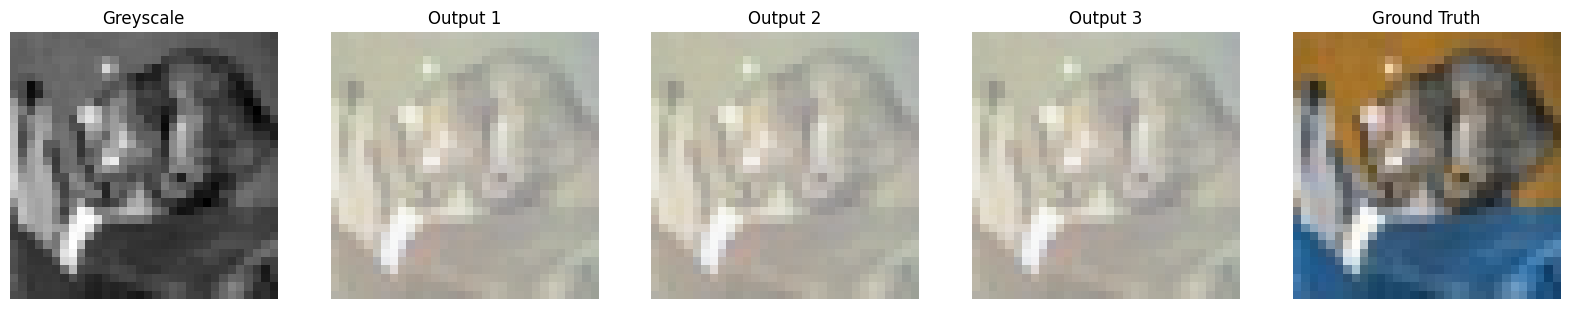

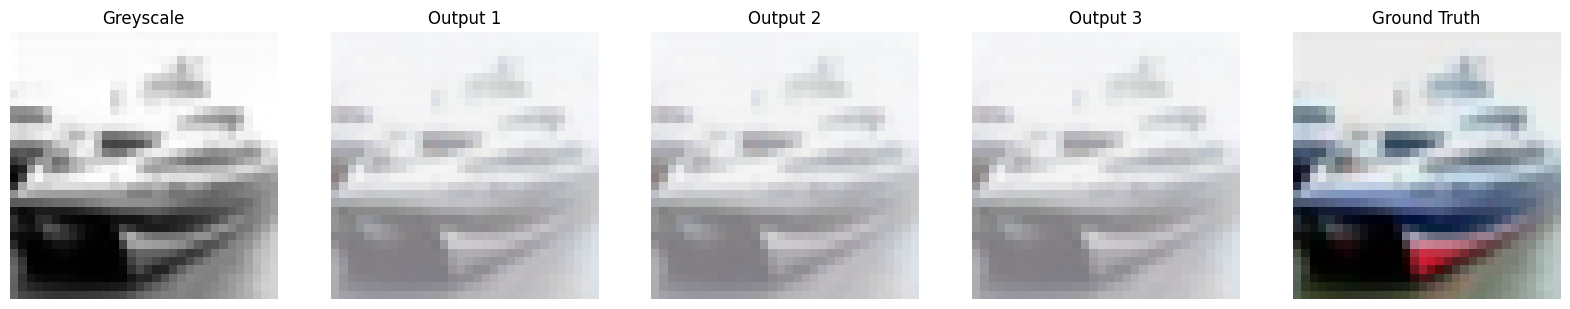

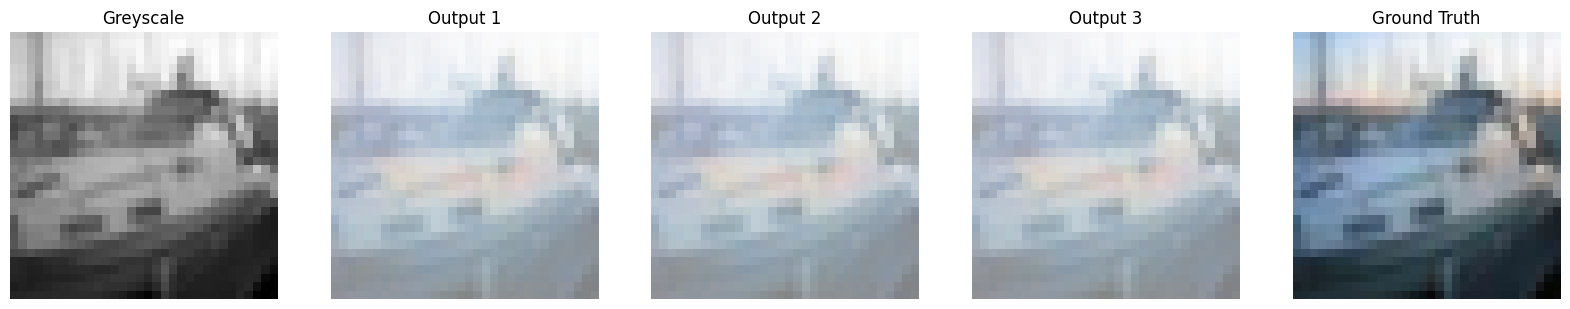

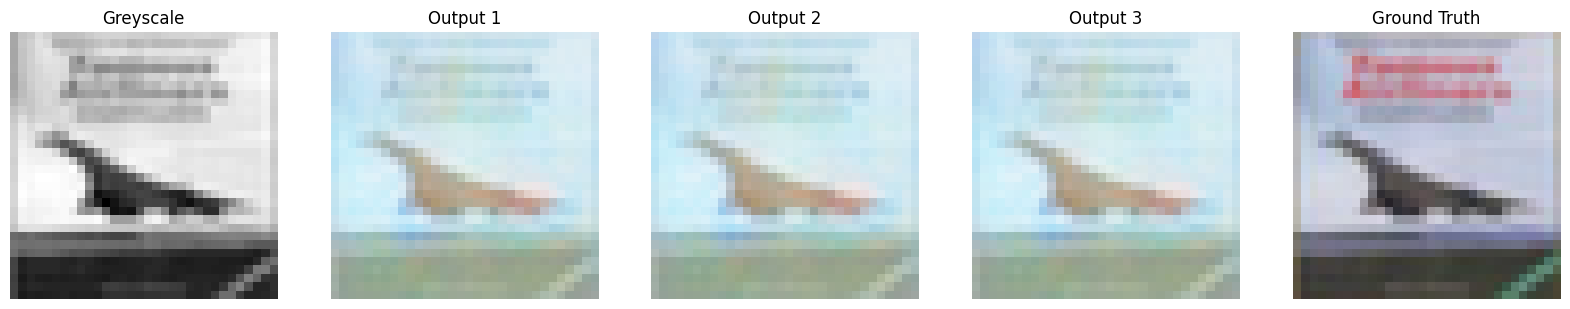

In [43]:
show_cifar_variations(greyscale_batch, outputs, original_colour_batch)
